In [1]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import os
import math
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
random.seed(5)

In [2]:
import keras_tuner

In [3]:
def metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    print('MSE: '+str(mse))
    mae = mean_absolute_error(actual, predicted)
    print('MAE: '+str(mae))
    rmse = math.sqrt(mse)
    print('RMSE: '+str(rmse))
    return mse, mae, rmse

### Daily Data

In [5]:
dir = os.path.normpath(os.getcwd() + os.sep + os.pardir)+"/Data/"
df = pd.read_csv(f"{dir}guwahati.csv")
df.rename(columns={'date':'Date', 'rainfall':'Rain'}, inplace=True)
df['Date'] =  pd.to_datetime(df['Date'], infer_datetime_format=True)

df.head(), df.tail()

(        Date      Rain
 0 1901-01-01  0.631025
 1 1901-01-02  2.865568
 2 1901-01-03  0.000000
 3 1901-01-04  0.000000
 4 1901-01-05  0.000000,
             Date      Rain
 43094 2018-12-27  0.000000
 43095 2018-12-28  0.911493
 43096 2018-12-29  0.000000
 43097 2018-12-30  0.000000
 43098 2018-12-31  0.000000)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43099 entries, 0 to 43098
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    43099 non-null  datetime64[ns]
 1   Rain    43099 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 673.5 KB


In [7]:
train_index = int(df.shape[0] * 0.8)
train_index

34479

In [8]:

# split_index = df.loc[df['date'] == pd.to_datetime('2002-06-23', format='%Y-%m-%d')].index[0]
# train_df, test_df = df[:split_index+1], df[split_index+1:]

train_df, test_df = df[:train_index], df[train_index:]
train_len = len(train_df)
test_len = len(test_df)
train_df.shape, test_df.shape

((34479, 2), (8620, 2))

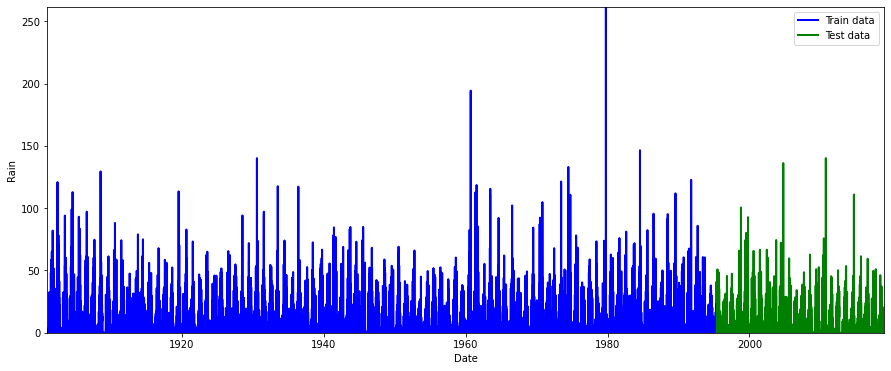

In [9]:
fig, ax = plt.subplots(figsize=(15,6))
plt.plot(train_df['Date'], train_df['Rain'], linewidth=2, color='blue', label='Train data')
plt.plot(test_df['Date'], test_df['Rain'], linewidth=2, color='green', label='Test data')
# plt.vlines(x=pd.to_datetime('2002-06-23', format='%Y-%m-%d'), ymin=0, ymax=300 ,color = 'k', linestyle=':')
plt.margins(x=0, y=0)
plt.xlabel('Date')
plt.ylabel('Rain')
plt.legend()
plt.show()

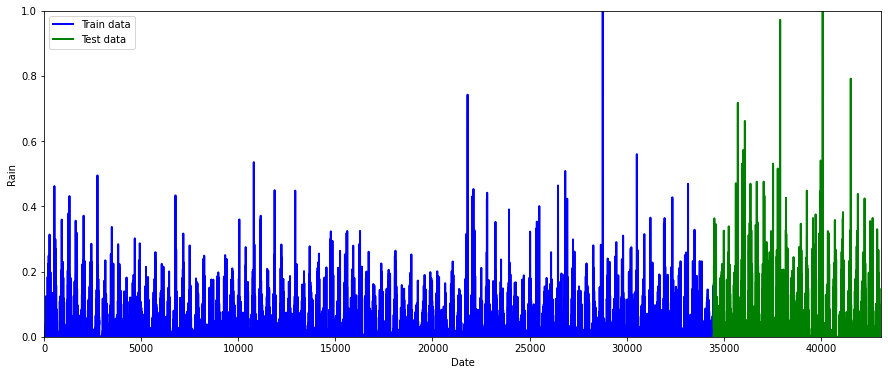

In [10]:
time_step = 7
period = 1

scaler = MinMaxScaler(feature_range=(0,1))
train_data_scaled = scaler.fit_transform(train_df.drop('Date',axis=1))

fig, ax = plt.subplots(figsize=(15,6))
plt.plot( np.arange(train_index) ,train_data_scaled, linewidth=2, color='blue', label='Train data')
plt.plot(np.arange(train_index, df.shape[0]) ,scaler.fit_transform(test_df.drop('Date',axis=1)), linewidth=2, color='green', label='Test data')

# plt.vlines(x=pd.to_datetime('2002-06-23', format='%Y-%m-%d'), ymin=0, ymax=300 ,color = 'k', linestyle=':')
plt.margins(x=0, y=0)
plt.xlabel('Date')
plt.ylabel('Rain')
plt.legend()
plt.show()


In [11]:

X_train = []
Y_train = []
for i in range(time_step,train_len):
    X_train.append(train_data_scaled[i-time_step:i,0])
    Y_train.append(train_data_scaled[i:i+period,0])

X_train, Y_train = np.array(X_train), np.array(Y_train)

X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

inp = df.drop('Date',axis=1)
inp = np.array(inp[(len(inp)-test_len-time_step):])

inp = scaler.transform(inp)

X_test = []

for i in range(time_step,test_len+time_step):
    X_test.append(inp[i-time_step:i,0])        
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))


In [12]:
X_train.shape

(34472, 7, 1)

In [13]:
Y_train.shape

(34472, 1)

In [14]:
def build_model(hp):

    period = 1
    window_size = 7 

    model = Sequential()
    model.add(LSTM( hp.Choice('units', [32, 64 ]) , input_shape=(window_size,1)))
    model.add(Dense(period, activation='linear'))

    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

In [19]:
tuner = keras_tuner.tuners.BayesianOptimization(
    build_model,
    objective="val_accuracy",
    max_trials=4,
)

print("[INFO] Tuning hyperparameters")

print(tuner.search_space_summary())


callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4,verbose=1,mode='max'),
tf.keras.callbacks.TensorBoard("/tmp/tb_logs")]

tuner.search(X_train,Y_train, workers=10, epochs=5, callbacks=[callbacks], validation_split=0.1)

best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

best_model = tuner.get_best_models(1)[0]


print("[INFO] Printing best hyperparameters")
print(best_hyperparameters.values)

print("[INFO] Printing summary ")

print(tuner.results_summary())

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
[INFO] Tuning hyperparameters
Search space summary
Default search space size: 1
units (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64], 'ordered': True}
None

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
32                |?                 |units

Epoch 1/30


2022-12-20 17:56:51.947732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-20 17:56:52.441783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-20 17:56:58.152395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


970/970 [==============================] - ETA: 0s - loss: 0.0013

2022-12-20 17:57:28.692690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-20 17:57:28.800036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


970/970 [==============================] - 40s 30ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 2/30
970/970 [==============================] - 26s 27ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 3/30
970/970 [==============================] - 27s 28ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 4/30
970/970 [==============================] - 30s 30ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 5/30
970/970 [==============================] - 29s 29ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 6/30
970/970 [==============================] - 29s 30ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 7/30
970/970 [==============================] - 27s 28ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/30
970/970 [==============================] - 27s 28ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/30
970/970 [==============================] - 28s 29ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/30
970/970 [==============================] - 29s 29ms/step - loss: 0.0012 - val_los

KeyError: 'val_accuracy'

In [ ]:
predictions = best_model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

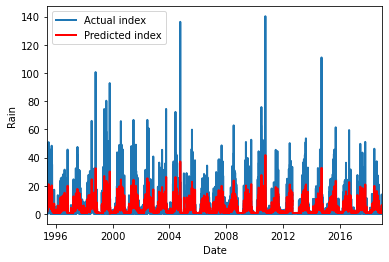

In [ ]:
predict = pd.DataFrame(columns = ['Date','Rain', 'Prediction'])
pred_data = test_df
predict['Date'] = pred_data['Date'][0:len(predictions)]
predict['Rain'] = pred_data['Rain'][0:len(predictions)]
predict['Prediction'] = predictions[:,0]

plt.plot(predict['Date'], predict['Rain'], label='Actual index', linewidth=2)
plt.plot(predict['Date'], predict['Prediction'], label='Predicted index', color='red', linewidth=2)
plt.legend()
plt.margins(x=0)
plt.xlabel('Date')
plt.ylabel('Rain')

plt.show()

In [ ]:
mse, mae, rmse = metrics(test_df['Rain'], predictions.reshape(test_df.shape[0]))

MSE: 57.710407344168196
MAE: 4.015938781149781
RMSE: 7.596736624641412


## Monthly Average Data

In [ ]:
# data_arr = np.load(f"{dir}monthly_avg.npy")
# dates = pd.date_range(start='1901-01-01', end='2018-12-31', freq='m')
# df = pd.DataFrame({'Date':dates, 'Rain':data_arr[10,:]})

# df.sort_values(by="Date", inplace=True)
# split_index = df.loc[df['Date']==pd.to_datetime('2002-06-30', format='%Y-%m-%d')].index[0]
# train_df, test_df = df[:split_index+1], df[split_index+1:]
# train_len = len(train_df)
# test_len = len(test_df)
# train_df, test_df

In [ ]:
# fig, ax = plt.subplots(figsize=(15,6))
# plt.plot(train_df['Date'], train_df['Rain'], linewidth=2, color='blue', label='Train data')
# plt.plot(test_df['Date'], test_df['Rain'], linewidth=2, color='green', label='Test data')
# plt.vlines(x=pd.to_datetime('2002-06-23', format='%Y-%m-%d'), ymin=0, ymax=50, color = 'k', linestyle=':')
# plt.margins(x=0, y=0)
# plt.xlabel('Date')
# plt.ylabel('Rain')
# plt.legend()
# plt.show()

In [ ]:
# time_step = 1
# period = 1

# train_data_scaled = scaler.fit_transform(train_df.drop('Date',axis=1))

# X_train = []
# Y_train = []
# for i in range(time_step,train_len):
#     X_train.append(train_data_scaled[i-time_step:i,0])
#     Y_train.append(train_data_scaled[i:i+period,0])

# X_train, Y_train = np.array(X_train), np.array(Y_train)

# X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

# inp = df.drop('Date',axis=1)
# inp = np.array(inp[(len(inp)-test_len-time_step):])

# inp = scaler.transform(inp)

# X_test = []

# for i in range(time_step,test_len+time_step):
#     X_test.append(inp[i-time_step:i,0])        
# X_test = np.array(X_test)

# X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [ ]:
# model = load_model(X_train)

# model.compile(optimizer='adam', loss='mean_squared_error')
# model.fit(X_train, Y_train, epochs=5, batch_size=150, verbose=1)
# predictions = model.predict(X_test)
# predictions = scaler.inverse_transform(predictions)

In [ ]:
# predict = pd.DataFrame(columns = ['Date','Rain', 'Prediction'])
# pred_data = test_df
# predict['Date'] = pred_data['Date'][0:len(predictions)]
# predict['Rain'] = pred_data['Rain'][0:len(predictions)]
# predict['Prediction'] = predictions[:,0]

# plt.plot(predict['Date'], predict['Rain'], label='Actual index', linewidth=2)
# plt.plot(predict['Date'], predict['Prediction'], label='Predicted index', color='red', linewidth=2)
# plt.legend()
# plt.margins(x=0)
# plt.xlabel('Date')
# plt.ylabel('Rain')

# plt.show()

In [ ]:
# mse, mae, rmse = metrics(test_df['Rain'],predictions.reshape(test_df.shape[0]))